In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

class GaussianBlur(Layer):
    def __init__(self, kernel_size=5, sigma=1.0, **kwargs):
        super(GaussianBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.sigma = sigma

    def build(self, input_shape):
        ax = tf.range(-self.kernel_size // 2 + 1, self.kernel_size // 2 + 1, dtype=tf.float32)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx**2 + yy**2) / (2. * self.sigma**2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.expand_dims(kernel, axis=-1)
        kernel = tf.expand_dims(kernel, axis=-1)
        kernel = tf.repeat(kernel, input_shape[-1], axis=-1)
        self.kernel = tf.Variable(kernel, trainable=False)

    def call(self, x):
        return tf.nn.depthwise_conv2d(x, self.kernel, strides=[1, 1, 1, 1], padding='SAME')


def load_images_label_pairs(images , labels, image_dir, label_dir, step=1, step_size=1000, add_noise=False):
    image_files = sorted(os.listdir(image_dir))  # Sort to maintain consistency
    label_files = sorted(os.listdir(label_dir))

    images =[]
    labels=[]

    # currupted_images = [2355, 2365, 2366]
    print("Images count: " + str(len(image_files)))
    for img, label in zip(image_files[step * step_size: (step + 1) * step_size], label_files[step * step_size: (step + 1) * step_size]):
        # print("Processing image: " + img + " with label: " + label)
        img_path = os.path.join(image_dir, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Adjust if images are colored
        if add_noise == True:
            noise = np.random.normal(loc=0, scale=10, size=img.shape).astype(np.float32)
            img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)
        images.append(img)


        label_path = os.path.join(label_dir, label)
        label = np.load(label_path)
        label = cv2.resize(label, (128, 128))  # Resize to match the image size
        labels.append(label)

    # return images, labels
    return np.array(images), np.array(labels)


def dice_coefficient_multiclass(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for multi-class segmentation with sparse labels"""
    # Convert sparse labels to one-hot if needed
    if len(y_true.shape) != len(y_pred.shape):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        y_true = tf.cast(y_true, tf.float32)
    
    # Flatten tensors
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return tf.reduce_mean(dice)

def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    """Dice loss for multi-class segmentation"""
    return 1 - dice_coefficient_multiclass(y_true, y_pred, smooth)

def focal_loss_multiclass(gamma=2., alpha=0.25):
    """Focal loss for multi-class segmentation with sparse labels"""
    def focal_loss_fixed(y_true, y_pred):
        # Convert sparse labels to one-hot if needed
        if len(y_true.shape) != len(y_pred.shape):
            y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
            y_true_onehot = tf.cast(y_true_onehot, tf.float32)
        else:
            y_true_onehot = y_true
            
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        ce = -y_true_onehot * tf.math.log(y_pred)
        
        # Calculate focal weight
        p_t = tf.where(tf.equal(y_true_onehot, 1), y_pred, 1 - y_pred)
        alpha_factor = y_true_onehot * alpha + (1 - y_true_onehot) * (1 - alpha)
        modulating_factor = tf.pow((1 - p_t), gamma)
        
        # Apply focal weight
        focal_ce = alpha_factor * modulating_factor * ce
        
        return tf.reduce_mean(tf.reduce_sum(focal_ce, axis=-1))
    
    return focal_loss_fixed

def weighted_categorical_crossentropy(class_weights):
    """Weighted categorical crossentropy for handling class imbalance"""
    def loss(y_true, y_pred):
        # Convert sparse labels to one-hot if needed
        if len(y_true.shape) != len(y_pred.shape):
            y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
            y_true_onehot = tf.cast(y_true_onehot, tf.float32)
        else:
            y_true_onehot = y_true
            
        # Apply class weights
        weights = tf.reduce_sum(class_weights * y_true_onehot, axis=-1)
        
        # Calculate categorical crossentropy
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        loss = -tf.reduce_sum(y_true_onehot * tf.math.log(y_pred), axis=-1)
        
        return tf.reduce_mean(weights * loss)
    
    return loss

# IoU Metric for multi-class
def iou_metric_multiclass(y_true, y_pred, smooth=1e-6):
    # Convert predictions to class labels
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(tf.cast(y_true_f == y_pred_f, tf.float32))
    union = tf.size(y_true_f, out_type=tf.float32)

    return (intersection + smooth) / (union + smooth)


# Improved Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.5
    else:
        return lr * 0.1

# Lightweight U-Net Model
def lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128), num_classes=4):
    inputs = Input(input_size, name="input_layer")
    
    # Preprocessing
    x = tf.keras.layers.Resizing(target_size[0], target_size[1], name="resize")(inputs)
    x = tf.keras.layers.Rescaling(1./255, name="rescale")(x)
    
    # Optional Gaussian Blur (comment out if not needed)
    x = GaussianBlur(name="gaussian_blur")(x)

    # Encoder Path
    # Block 1
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    # Block 2
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.2)(p2)

    # Block 3
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.4)(c4)

    # Decoder Path
    # Block 5
    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)

    # Block 6
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)

    # Block 7
    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs, name="improved_unet")
    
    # Compile with better optimizer and metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',  # Keep it simple for now
        metrics=['accuracy', dice_coefficient_multiclass, iou_metric_multiclass]
    )

    return model


2025-06-19 19:30:24.611253: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 19:30:24.843290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750341624.956469     900 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750341624.981666     900 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750341625.150152     900 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])  # 6GB in MB
    except RuntimeError as e:
        print(e)

callbacks = [
        EarlyStopping(monitor='val_dice_coefficient', patience=15, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8),
        LearningRateScheduler(scheduler)
    ]


# Create model with flexible input size
light_unet = lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128), num_classes=4)
# light_unet.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

image_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/images'
label_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/labels'


images = []
labels = []

for step in range(2):

    images, labels = load_images_label_pairs(images , labels , image_dir_path, label_dir_path, step=step, step_size=10000, add_noise=True)
    print(f"Step {step + 1} - Loaded {len(images)} images and {len(labels)} labels.")
    # Print distinct labels in the current batch
    print("Distinct labels in this batch:", np.unique(labels))
    # labels = labels / np.max(labels)

    print("Loaded images shape: ", images.shape)
    print("Loaded labels shape: ", labels.shape)
    img_train, img_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    print(f"Training images shape: {len(img_train)}")
    print(f"Training labels shape: {len(label_train)}")
    print(f"Testing images shape: {len(img_test)}")
    print(f"Testing labels shape: {len(label_test)}")

    history = light_unet.fit(
            img_train, label_train,
            validation_data=(img_test, label_test),
            epochs=50,  # Increased epochs
            batch_size=8,  # Slightly larger batch size
            callbacks=callbacks,
            shuffle=True,
            verbose=1
        )
    
        
# Save the model
light_unet.save('light_weight_unet_gaze_estimation_model_noise.h5')  # <-- Typo fixed


I0000 00:00:1750180552.928836   22107 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Images count: 27431
Step 1 - Loaded 10000 images and 10000 labels.
Distinct labels in this batch: [0 1 2 3]
Loaded images shape:  (10000, 400, 640)
Loaded labels shape:  (10000, 128, 128)
Training images shape: 8000
Training labels shape: 8000
Testing images shape: 2000
Testing labels shape: 2000
Epoch 1/50


I0000 00:00:1750180708.127649   22403 service.cc:152] XLA service 0x7be8f0040e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750180708.128572   22403 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-06-17 22:48:28.403950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750180709.660942   22403 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750180726.748717   22403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.7890 - dice_coefficient_multiclass: 0.3879 - iou_metric_multiclass: 0.7890 - loss: 0.7224 - val_accuracy: 0.9826 - val_dice_coefficient_multiclass: 0.7968 - val_iou_metric_multiclass: 0.9826 - val_loss: 0.0741 - learning_rate: 1.0000e-04
Epoch 2/50
   3/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9819 - dice_coefficient_multiclass: 0.7084 - iou_metric_multiclass: 0.9819 - loss: 0.1095

/home/yasas/GazeEstimation/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_dice_coefficient` which is not available. Available metrics are: accuracy,dice_coefficient_multiclass,iou_metric_multiclass,loss,val_accuracy,val_dice_coefficient_multiclass,val_iou_metric_multiclass,val_loss
  current = self.get_monitor_value(logs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9821 - dice_coefficient_multiclass: 0.7585 - iou_metric_multiclass: 0.9821 - loss: 0.0868 - val_accuracy: 0.9883 - val_dice_coefficient_multiclass: 0.8787 - val_iou_metric_multiclass: 0.9883 - val_loss: 0.0385 - learning_rate: 1.0000e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9858 - dice_coefficient_multiclass: 0.8535 - iou_metric_multiclass: 0.9858 - loss: 0.0495 - val_accuracy: 0.9891 - val_dice_coefficient_multiclass: 0.9185 - val_iou_metric_multiclass: 0.9891 - val_loss: 0.0312 - learning_rate: 1.0000e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9876 - dice_coefficient_multiclass: 0.8951 - iou_metric_multiclass: 0.9876 - loss: 0.0380 - val_accuracy: 0.9904 - val_dice_coefficient_multiclass: 0.9357 - val_iou_metric_multiclass: 0.9904 - val_loss: 0.0259 - learning_rate: 1.0000e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.9887 - dice_coeff

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


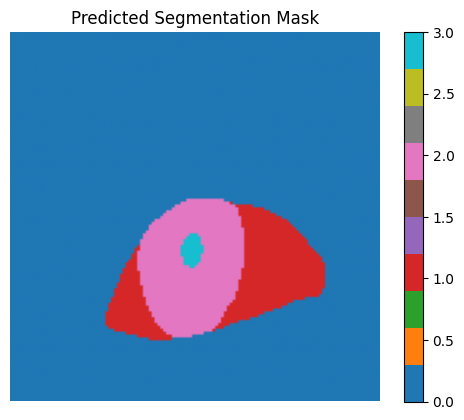

<Figure size 640x480 with 0 Axes>

In [24]:
from tensorflow.keras.models import load_model

add_noise = True  # Set to True if you want to add noise like during training

light_unet = load_model("light_weight_unet_gaze_estimation_model_noise.h5", custom_objects={
    'dice_coefficient_multiclass': dice_coefficient_multiclass,
    'iou_metric_multiclass': iou_metric_multiclass,
    'GaussianBlur': GaussianBlur
})

image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/images/000100.png'  # Assuming grayscale image
# Step 1: Read the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # shape: (H, W)

# Step 2: (Optional) Add Gaussian noise like during training
if add_noise:
    noise = np.random.normal(loc=0, scale=10, size=img.shape).astype(np.float32)
    img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

# Step 3: Expand dimensions to shape (1, H, W, 1)
img_input = np.expand_dims(img, axis=(0, -1))  # e.g., (1, 240, 320, 1)

# Step 4: Predict with the model
pred = light_unet.predict(img_input)  # Output shape: (1, 128, 128, 4) due to resizing inside model

# Step 5: Convert softmax to class labels
predicted_mask = np.argmax(pred, axis=-1)[0]  # Shape: (128, 128)

plt.imshow(predicted_mask, cmap='tab10', vmin=0, vmax=3)
plt.title("Predicted Segmentation Mask")
plt.colorbar()
plt.axis('off')
plt.show()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


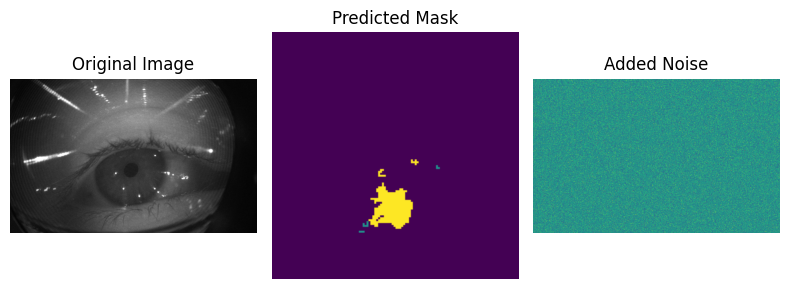

<Figure size 640x480 with 0 Axes>

In [ ]:
# Re-define dice_loss again (important!)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Now load the model properly
light_unet = load_model("light_weight_unet_gaze_estimation_model_noise.h5", custom_objects={
    'dice_coefficient_multiclass': dice_coefficient_multiclass,
    'iou_metric_multiclass': iou_metric_multiclass,
    'GaussianBlur': GaussianBlur
})

# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/images/000110.png'  # Assuming grayscale image
# image_path = '/home/yasas/GazeEstimation/412.jpg'  # Assuming grayscale image

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if add_noise:
    noise = np.random.normal(loc=0, scale=10, size=img.shape).astype(np.float32)
    img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

# Step 3: Expand dimensions to shape (1, H, W, 1)
img_input = np.expand_dims(img, axis=(0, -1)) 

# Predict the output using the model
predicted_mask = light_unet.predict(img_input)

# # Remove batch dimension to get the mask image
predicted_mask = np.argmax(predicted_mask, axis=-1)[0] # Shape: (height, width)

original_shape = image.shape

plt.figure(figsize=(8, 8))

# Top-left: Original Image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Top-right: Predicted Mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

# Bottom-left: Added Noise
plt.subplot(1, 3, 3)
plt.imshow(noise, cmap='viridis')
plt.title('Added Noise')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# Optional: If you need to save the mask
# cv2.imwrite('predicted_mask.png', (predicted_mask * 255).astype(np.uint8))

In [ ]:
from tensorflow.keras.utils import model_to_dot
import pydot
from IPython.display import Image

dot = model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=300)  # High DPI
dot.set_rankdir('TB')  # Top-Bottom layout

# Save the PNG
dot.write_png('model_plot.png')

# Display
Image(filename='model_plot.png')



In [ ]:
model.summary()

In [51]:

def round_predictions(y_pred):
    y_pred_rounded = np.zeros_like(y_pred)
    y_pred_rounded[y_pred > 0.9] = 1
    y_pred_rounded[(y_pred > 0.4) & (y_pred <= 0.9)] = 0.67
    y_pred_rounded[(y_pred > 0.2) & (y_pred <= 0.4)] = 0.33
    y_pred_rounded[y_pred <= 0.2] = 0.0
    return y_pred_rounded

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step


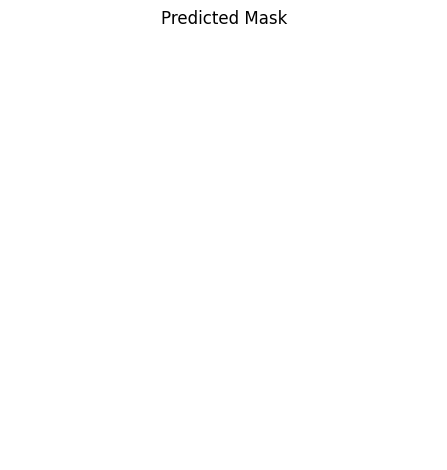

In [52]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
model = load_model('light_weight_unet_gaze_estimation_model_noise.h5',
                   custom_objects={'dice_loss': dice_loss, 'GaussianBlur': GaussianBlur})
# Expand dims to add channel (1 for grayscale)
X_test_fixed = np.expand_dims(img_train, axis=-1)  # Shape: (1600, 400, 640, 1)

# Now predict
y_pred = model.predict(X_test_fixed, batch_size=4, verbose=1)

plt.imshow(round_predictions(y_pred[70]))
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [83]:
def calculate_miou_multiclass(y_true, y_pred, classes):
    ious = []
    for cls in classes:
        true_mask = (y_true == cls).astype(np.float32)
        pred_mask = (y_pred == cls).astype(np.float32)

        true_mask = (abs(y_true - cls)< 0.01).astype(np.float32)
        pred_mask = (abs(y_pred - cls) < 0.01).astype(np.float32)

        intersection = np.sum(true_mask * pred_mask)
        union = np.sum(true_mask) + np.sum(pred_mask) - intersection

        if union > 0:
            iou = intersection / union
        else:
            iou = 1.0  # If both true and pred are empty
        ious.append(iou)

    return np.mean(ious)

unique_classes = np.unique(labels)
y_pred_squeeze = np.squeeze(y_pred, axis = -1)  # Remove batch dimension
miou_score = calculate_miou_multiclass(y_pred_squeeze, label_train, classes=unique_classes)
print(f"mIoU: {miou_score:.4f}")


ValueError: cannot select an axis to squeeze out which has size not equal to one

In [14]:
def dice_score(y_true, y_pred, classes):
    dices = []
    for cls in classes:
        true_mask = (np.abs(y_true - cls) < 0.01).astype(np.float32)
        pred_mask = (np.abs(y_pred - cls) < 0.01).astype(np.float32)

        intersection = 2.0 * np.sum(true_mask * pred_mask)
        denominator = np.sum(true_mask) + np.sum(pred_mask)

        dice = intersection / denominator if denominator > 0 else 1.0
        dices.append(dice)
        print(f"Dice for class {cls}: {dice:.4f}")

    mean_dice = np.mean(dices)
    print(f"\nMean Dice: {mean_dice:.4f}")
    return mean_dice

unique_classes = np.unique(labels)
num_classes = 4  # Example: background, iris, pupil
y_pred_squeeze = np.squeeze(y_pred, axis = -1)  # Remove batch dimension
miou_score = dice_score(y_pred_squeeze, label_train, num_classes=unique_classes)
unique_classes = np.unique(y_pred_squeeze)
print(f"Unique classes in predicted mask: {unique_classes}")
print(f"Dice coefficient is : {miou_score:.4f}")

TypeError: dice_score() got an unexpected keyword argument 'num_classes'

In [6]:
from tensorflow.keras.models import Model

# Create the original model
base_model = lightweight_unet_model()

# Put all the layers in the model into a list
layer_names = [layer.name for layer in base_model.layers]

print(layer_names)

# Get layer outputs by name
feature_layers = [base_model.get_layer(name).output for name in layer_names]

# Create a new model that outputs these feature maps
feature_map_model = Model(inputs=base_model.input, outputs=feature_layers)


I0000 00:00:1747459048.523563     966 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3600 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


['input_layer', 'resize', 'rescale', 'encoder_conv1', 'encoder_bn1', 'encoder_pool1', 'encoder_conv2', 'encoder_bn2', 'encoder_pool2', 'bottleneck_conv', 'decoder_up1', 'decoder_concat1', 'decoder_conv1', 'decoder_bn1', 'decoder_up2', 'decoder_concat2', 'decoder_conv2', 'decoder_bn2', 'output_layer']


In [ ]:

image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/S_192/120.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
int_image = np.expand_dims(image, axis=0)  # Add batch dimension: (1, height, width)
input_image = np.expand_dims(int_image, axis=-1)  # Add channel dimension: (1, height, width, 1)

# Predict the output using the model
feature_maps = feature_map_model.predict(input_image)

for i, fmap in enumerate(feature_maps):
    plt.figure(figsize=(10, 5))
    plt.title(f"Layer {layer_names[i]} - Feature Map")
    plt.imshow(fmap[0, :, :, 0], cmap='viridis')  # showing only first channel
    plt.colorbar()
    plt.show()
